# CONSTRUCTION SITE SAFETY DETECTOR

In this project we are going to learn: 
* How to train YOLO model on our own custom data
* How to plot all the prediction

And build a simple project a safety checker which will tell us if the person is safe to work on the construction site. This will be done by checking if the person is wearing
  * Gloves
  * Hardhat
  * Mask
  * Safety Vest

# Content
* [Installation](#Installation)
* [Imports](#Imports)
* [Getting the data](#Getting-the-data)
* [Traning the model](#Traning-the-model)
* [Loading our model](#Loading-the-model)
* [Preparing our Image](#Preparing-our-Image)
* [Plotting all the prediction](#Plotting-all-the-predictions)
* [Build a Simple Safety Checker](#Build-a-Simple-Safety-Checker)


# Installation

In [ ]:
!pip install ultralytics cvzone

# Imports

In [64]:
from ultralytics import YOLO
import cv2
import IPython as ipy

import pandas as pd

# Getting the data

I am getting data from [Roboflow](https://universe.roboflow.com/roboflow-universe-projects/construction-site-safety/dataset/30)

Now there are two ways to get the data
* Either you download the data directly from the link above
* You can download it from the code

In this notebook we are going to go with the second option. So if you don't have the data run the below code cell to get it.


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="YOUR_API_KEY)")
project = rf.workspace("roboflow-universe-projects").project("construction-site-safety")
version = project.version(30)
dataset = version.download("yolov8")


We got our data. If you look inside the downloaded folder you will find `data.yaml` file

If you have different folder structurue make sure the path of train, test and valid in your `data.yaml` file should be with respect to your current notebook.

For example if your file structure is something like this.
* data
    * Construction-site-safety-30
        * data.yaml
* main.ipynb

then in your `data.yaml` you need to change the path for train, test, and valid to './data/Construction-site-safety-30/train/images'.

# Traning the model
Below cell will take time

In [ ]:
#!yolo task=detect mode=train model=yolov8l.pt data=./Construction-Site-Safety-30/data.yaml epochs=50 imgsz=640

If the above code is showing some error. That's fine you can run the above code in google colab or some other notebook which provides you GPU. And when the above code runs successfully it will give you a model just download it.

# Loading the model

In [65]:
model = YOLO("./model/best.pt")

# Getting all the labels that our model has learned
dict_classes = model.model.names
print(dict_classes)

{0: 'Excavator', 1: 'Gloves', 2: 'Hardhat', 3: 'Ladder', 4: 'Mask', 5: 'NO-Hardhat', 6: 'NO-Mask', 7: 'NO-Safety Vest', 8: 'Person', 9: 'SUV', 10: 'Safety Cone', 11: 'Safety Vest', 12: 'bus', 13: 'dump truck', 14: 'fire hydrant', 15: 'machinery', 16: 'mini-van', 17: 'sedan', 18: 'semi', 19: 'trailer', 20: 'truck and trailer', 21: 'truck', 22: 'van', 23: 'vehicle', 24: 'wheel loader'}


# Preparing our Image

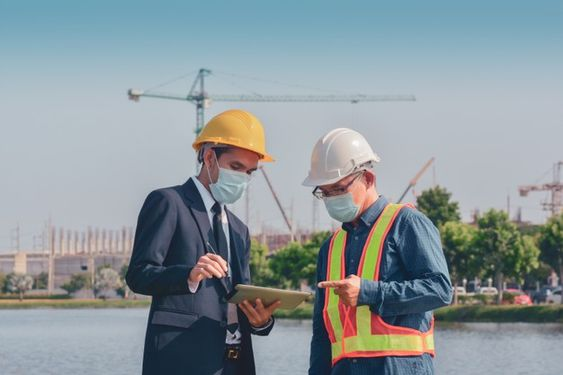

In [66]:
IMAGE_PATH = "./assets/images/image-5.jpg"
frac = 0.65
ipy.display.Image(data = IMAGE_PATH, height = int(720 * frac), width = (1280 * frac))

# Plotting all the predictions

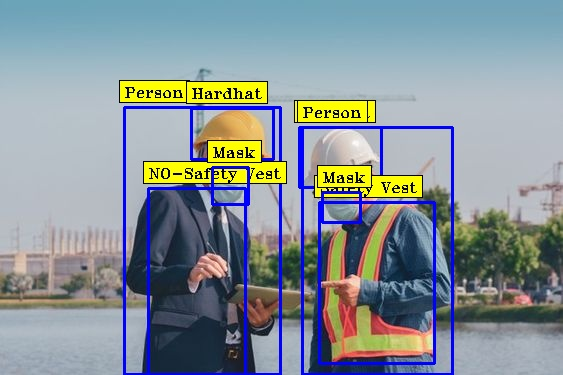

In [70]:
image = cv2.imread(IMAGE_PATH)

# Get the index for all the labels
class_IDS = list(dict_classes.keys())

prediction = model.predict(image, conf=0.7, classes = class_IDS, verbose=False, device=0)

classes = prediction[0].boxes.cls.cpu().numpy()
labels = [dict_classes[index] for index in classes]
image_df = pd.DataFrame(prediction[0].cpu().numpy().boxes.data, columns=['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'cls'])
for ix, rows in enumerate(image_df.iterrows()):
    xmin, ymin, xmax, ymax, confidense, category = rows[1]
    xmin, ymin, xmax, ymax, category = map(int, [xmin, ymin, xmax, ymax, category])

    cv2.rectangle(image, pt1=(xmin, ymin), pt2=(xmax, ymax), color=(255, 0, 0), thickness=2)

    text_size, _ = cv2.getTextSize(f'{labels[ix]}', cv2.FONT_HERSHEY_TRIPLEX, 0.5, 1)
    padding = 5
    border_thickness = 1

    cv2.rectangle(image, pt1=(xmin - padding, ymin - text_size[1] - 10 - padding), 
                  pt2=(xmin + padding + text_size[0], ymin - 10 + padding),
                  color=(0, 255, 255), thickness=cv2.FILLED)

    cv2.rectangle(image, 
                  pt1=(xmin - padding, ymin - text_size[1] - 10 - padding), 
                  pt2=(xmin + padding + text_size[0], ymin - 10 + padding),
                  color=(0, 0, 0), 
                  thickness=border_thickness)

    cv2.putText(img=image, text=f'{labels[ix]}', org=(xmin, ymin - 10), fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                fontScale=0.5, color=(0, 0, 0), thickness=1)
    
   
ipy.display.Image(data=cv2.imencode('.jpeg', image)[1], height = int(720 * frac), width = (1280 * frac))

Let's try to figure out what the above line of code means

`image = cv2.imread(IMAGE_PATH)`

This line is using OpenCV to read the image from the given path

`class_IDS = list(dict_classes.keys())`

For making prediction we need the ids of our labels. Our labels are store in a dictionary named `dict_classes`. The `keys` of the dictionary are nothing but the index of each label

`classes = prediction[0].boxes.cls.cpu().numpy()`

`labels = [dict_classes[index] for index in classes]`

Getting all the index value which our model predict and storing it in the variable named `classes` but we don't need index we want the acutal name. So we are using `labels` variable to store all the names that our model predicted

`image_df = pd.DataFrame(prediction[0].cpu().numpy().boxes.data, columns=['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'cls'])`

Now to plot the each item in the image we need: 
* x and y coordinate
* confidence value
* What it is

To store all these information I am using `pandas` and we get all the above said points from `prediction[0].cpu().numpy().boxes.data`.

But why are we doing this `cpu().numpy()`. `cpu()` and `numpy()` are being used to convert the data from a GPU tensor format to a CPU numpy array format before creating a Pandas DataFrame. The `cpu()` method moves the tensor data from the GPU memory to the CPU memory. Neural network models often perform computations on GPU for faster processing. However, some operations (like creating a Pandas DataFrame) may require CPU memory, so cpu() is used to ensure compatibility.

`xmin, ymin, xmax, ymax, confidense, category = rows[1]`
`xmin, ymin, xmax, ymax, category = map(int, [xmin, ymin, xmax, ymax, category])`

Extracting all the information from the row and coverting them (except conf) to int

`cv2.rectangle(image, pt1=(xmin, ymin), pt2=(xmax, ymax), color=(255, 0, 0), thickness=2)`

This line will plot the rectangle on each predicted item

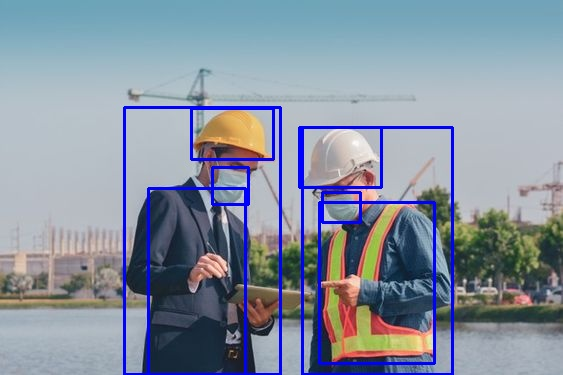

Now it's time to label each predicted box. Let's proceed step by step
* First let's put the text
`cv2.putText(img=image, text=f'{labels[ix]}', org=(xmin, ymin - 10), fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                fontScale=0.5, color=(0, 0, 0), thickness=1)`

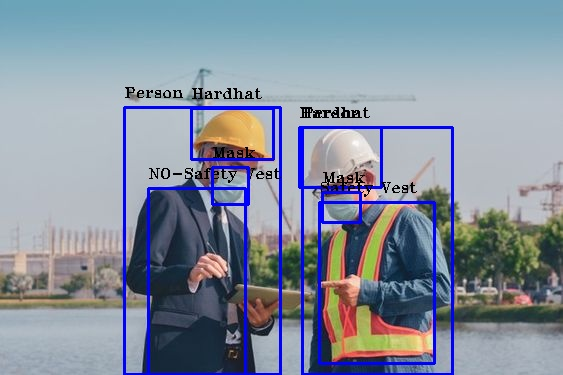

* It's good but let's put some background color behind the text.

`cv2.rectangle(image, pt1=(xmin - padding, ymin - 10), pt2=(xmin, ymin - 10), color=(0, 255, 255), thickness=cv2.FILLED)`

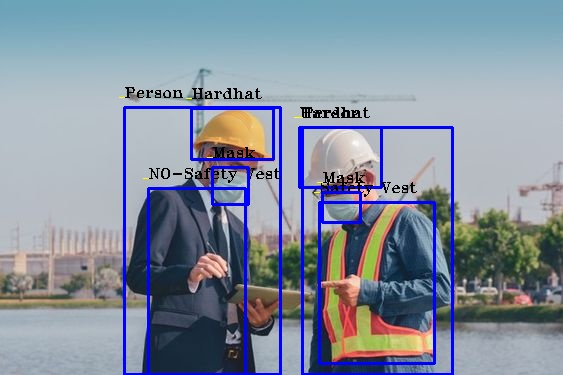

* Ahh, it not working. I think we need to define some height and width for this box. And height and width should be equal to the height and width of the text it contains. So we need to calculate that. We can do that using this code

`text_size, _ = cv2.getTextSize(f'{labels[ix]}', cv2.FONT_HERSHEY_TRIPLEX, 0.5, 1)`

and also need to add this text_size in our rectangle

`cv2.rectangle(image, pt1=(xmin, ymin - text_size[1] - 10), pt2=(xmin + text_size[0], ymin - 10),color=(0, 255, 255), thickness=cv2.FILLED)`

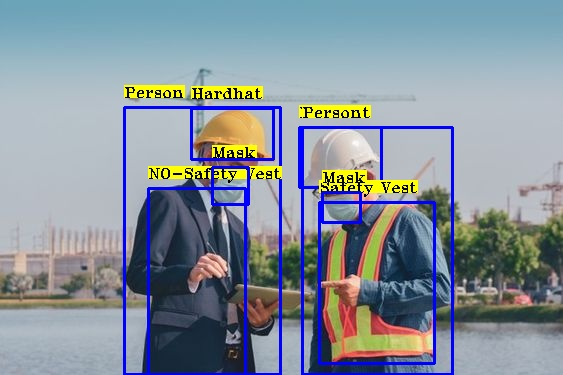

* Looking good but it will look more beautiful if we add some padding between the text and the rectangle. Create a variable named `padding` and put that in the rectangle

`cv2.rectangle(image, pt1=(xmin - padding, ymin - text_size[1] - 10 - padding),pt2=(xmin + padding + text_size[0], ymin - 10 + padding), color=(0, 255, 255), thickness=cv2.FILLED)`

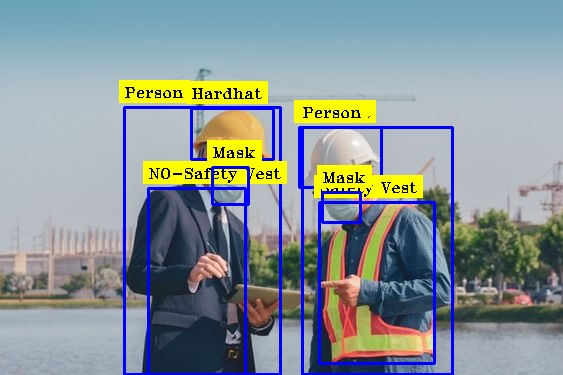

* Ahh, now it's look beautiful but there more we can do let's add a border to this yellow rectangle. Define a variable named `border_thickness` and add this code

`cv2.rectangle(image,pt1=(xmin - padding, ymin - text_size[1] - 10 - padding), pt2=(xmin + padding + text_size[0], ymin - 10 + padding),color=(0, 0, 0), thickness=border_thickness)`

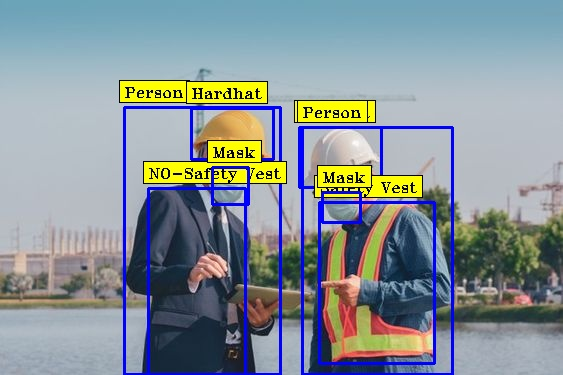

Right now the text are overlapping try to improve that something like this

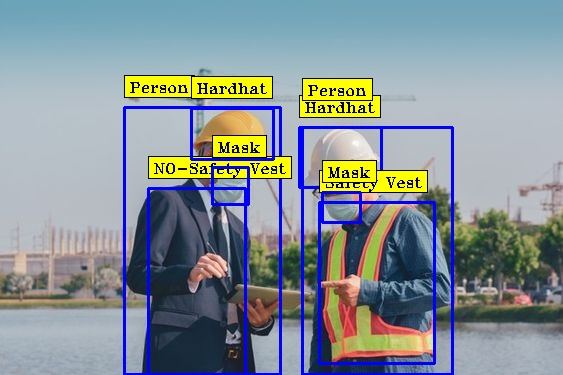


# Build a Simple Safety Checker
Now it's your turn using above knowledge build a simple safety checker.

----------------------INFO FROM BELOW IMAGE------------------------------
Total number of persons detected: 2

To be 100% secure you should be wearing : ['Gloves', 'Hardhat', 'Safety Vest', 'Mask']

-------------------ABOUT PERSON_1------------------------
Wearing: ['Hardhat', 'Safety Vest', 'Mask']
Safety Percentage: 75%
Not wearing: ['Gloves']

-------------------ABOUT PERSON_2------------------------
Wearing: ['Hardhat', 'Mask']
Safety Percentage: 50%
Not wearing: ['Gloves', 'Safety Vest']



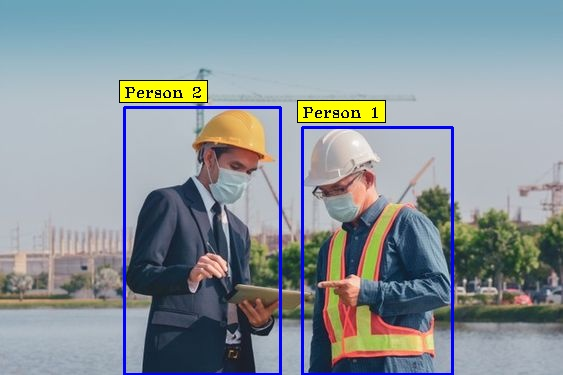

In [68]:
image = cv2.imread(IMAGE_PATH)

# Get the index for the labels we need
class_IDS = [1, 2, 4, 8, 11]
person_coor ={}
safety_coor = {}
number_of_persons, number_of_hardhat, number_of_safety_vest, number_of_mask, number_of_gloves = 0, 0, 0, 0, 0

prediction = model.predict(image, conf=0.7, classes = class_IDS, verbose=False, device=0)

classes = prediction[0].boxes.cls.cpu().numpy()
labels = [dict_classes[index] for index in classes]
image_df = pd.DataFrame(prediction[0].cpu().numpy().boxes.data, columns=['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'cls'])
for ix, rows in enumerate(image_df.iterrows()):
    xmin, ymin, xmax, ymax, confidense, category = rows[1]
    xmin, ymin, xmax, ymax, category = map(int, [xmin, ymin, xmax, ymax, category])
    

    if(labels[ix] == 'Person'):
            number_of_persons += 1
            person_coor[f'person_{number_of_persons}'] = (xmin, ymin, xmax, ymax)
            cv2.rectangle(image, pt1=(xmin, ymin), pt2=(xmax, ymax), color=(255, 0, 0), thickness=2)

            text_size, _ = cv2.getTextSize(f'Person {number_of_persons}', cv2.FONT_HERSHEY_TRIPLEX, 0.5, 1)
            padding = 5
            border_thickness = 1
        
            cv2.rectangle(image, pt1=(xmin - padding, ymin - text_size[1] - 10 - padding), 
                          pt2=(xmin + padding + text_size[0], ymin - 10 + padding),
                          color=(0, 255, 255), thickness=cv2.FILLED)
        
            cv2.rectangle(image, 
                          pt1=(xmin - padding, ymin - text_size[1] - 10 - padding), 
                          pt2=(xmin + padding + text_size[0], ymin - 10 + padding),
                          color=(0, 0, 0), 
                          thickness=border_thickness)
        
            cv2.putText(img=image, text=f'Person {number_of_persons}', org=(xmin, ymin - 10), fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                        fontScale=0.5, color=(0, 0, 0), thickness=1)
    else:
            center_x, center_y = int((xmin + xmax) / 2), int((ymin + ymax) / 2)
            safety_coor.setdefault(f'{labels[ix]}', []).append((center_x, center_y))
            
            
person_safety = {}
for p_key, p_coor in person_coor.items():
    for s_key, s_coor_list in safety_coor.items():
        for coor in s_coor_list:
            if(coor[0] >= p_coor[0] and coor[1] >= p_coor[1] and coor[0] <= p_coor[2] and coor[1] <= p_coor[3]):
                person_safety.setdefault(f'{p_key}', []).append(s_key)
                break

safety_equipment = ['Gloves', 'Hardhat', 'Safety Vest', 'Mask']
print("----------------------INFO FROM BELOW IMAGE------------------------------")
print(f'Total number of persons detected: {number_of_persons}\n')
print(f'To be 100% secure you should be wearing : {safety_equipment}\n')
for key, value in person_safety.items():
    print(f'-------------------ABOUT {key.upper()}------------------------')
    print(f'Wearing: {value}')
    print(f'Safety Percentage: {(len(value) / len(safety_equipment)) * 100:.0f}%')
    print(f'Not wearing: {[item for item in safety_equipment if item not in value]}')
    print()
ipy.display.Image(data=cv2.imencode('.jpeg', image)[1], height = int(720 * frac), width = (1280 * frac))